<a href="https://colab.research.google.com/github/bofori-tech/DS-Unit-2-Linear-Models/blob/master/Copy_of_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [ ]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [ ]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [ ]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [ ]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [ ]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [ ]:
df.info()

In [ ]:
df.shape

(421, 59)

In [ ]:

#Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2017-12-31')
train = df[df.Date <=cutoff]
test  = df[df.Date >= '2018']


In [ ]:
train.shape, test.shape, 

((383, 59), (38, 59))

In [ ]:
# we could do this manually but sklearn has a method for it.
from sklearn.model_selection import train_test_split

In [ ]:
# split "train" into "train" and "val"
train, val = train_test_split(train, random_state=42)

In [ ]:
#Show the shape
print(train.shape)
print(val.shape, test.shape)

(287, 59)
(96, 59) (38, 59)


In [ ]:
df['Great'] = df.Great.astype('category')

In [ ]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.574913
True     0.425087
Name: Great, dtype: float64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


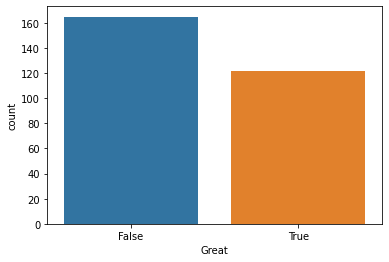

In [ ]:
# display that as a graphic.
import seaborn as sns
sns.countplot(y_train);

In [ ]:
# Remember, "mode" is the most frequent value -- which in this case is "0".
majority_class = y_train.mode()

In [ ]:
# create a list of zeroes as long as our training dataset.
y_pred = [majority_class] * len(y_train)
print(len(y_train))

287


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
# Training accuracy of majority class baseline = 
# frequency of majority class (aka base rate)
accuracy_score(y_train, y_pred)

0.5749128919860628

In [ ]:
# Validation accuracy of majority class baseline = 
# usually similar to Train accuracy
y_val = val[target]
y_pred = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred)

0.6041666666666666

In [ ]:
# 1. Import estimator class
from sklearn.linear_model import LinearRegression


In [ ]:
# 2. Instantiate this class
linear_reg = LinearRegression()

In [ ]:
# 3. Arrange X feature matrix (already did y target vectors)
features = ['Google', 'Cost', 'Hunger','Tortilla']
X_train = train[features]
X_val = val[features]

In [ ]:
# do we have any missing values?
X_train.isnull().sum()

Google      223
Cost          6
Hunger        2
Tortilla      0
dtype: int64

In [ ]:
# Impute missing values for google
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [ ]:
# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# 5. Apply the model to new data.
linear_reg.predict(X_val_imputed)

array([-0.08368726,  0.38746915,  0.41557384,  0.52690875,  0.47407116,
        0.38485638, -0.18574779,  0.59744768, -0.08368726,  0.50204616,
       -0.10213039,  0.32342147,  0.4851616 ,  0.05078109,  0.29241538,
        0.51627478,  0.58941352,  0.68631471,  0.40829877,  0.4668219 ,
        0.57618992,  0.16646935,  0.15387695,  0.55033082,  0.3087077 ,
        0.14421952,  0.62935326,  0.01790514,  0.23655007,  0.51829574,
        0.36283604,  0.02313024,  0.47929669,  0.4782198 ,  0.62226703,
        0.30524081,  0.10613165,  0.45415471,  0.52940661,  0.68884801,
        0.58450399,  0.63511278, -0.0422937 ,  0.42459418,  0.2860424 ,
       -0.19110302,  0.31737331,  0.22162192,  0.32758598,  0.5688363 ,
        0.48376101,  0.39960165,  0.66707573,  0.61368557,  0.26720763,
        0.60024669,  0.49628663,  0.08178415,  0.32405525,  0.53689193,
        0.32251938,  0.27069484,  0.15251234,  0.36108161,  0.56822284,
        0.50936025,  0.31990662,  0.34363763,  0.28665586,  0.12

In [ ]:
# Get coefficients
pd.Series(linear_reg.coef_, features)

Google     -0.151434
Cost        0.038397
Hunger      0.064048
Tortilla    0.241250
dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.6354166666666666


In [ ]:
# what are the coefficients for our predictors?
print(features)
print(log_reg.coef_)

['Google', 'Cost', 'Hunger', 'Tortilla']
[[-0.43332163  0.23164313  0.30114867  1.17792404]]


In [ ]:
# the intercept:  when all features are set to zero
log_reg.intercept_

array([-5.42669443])